## Lab # 2
_Tream 6_ <br>
_Abdurakhimov Muslimbek, Evgenii Kushakov, Alexandr Erofeevsky_

##### Dataset representation

Dataset name: Heart Disease Data Set
Preparation the dataset and subsample

Dataset is taken from: https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci

Dataset name: Heart Disease Cleveland UCI

##### Task formulation for regression. Estimation of multiple correlation

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import networkx as nx

from sklearn.linear_model import Lars
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

warnings.filterwarnings('ignore')

df = pd.read_csv('data.csv')

In [9]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [11]:
df = df[['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'target', 'slope']]

q75, q25 = np.percentile(df['age'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['age'] < min_dist) | (df['age'] > max_dist), ('age')] = np.nan

q75, q25 = np.percentile(df['trestbps'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['trestbps'] < min_dist) | (df['trestbps'] > max_dist), ('trestbps')] = np.nan

q75, q25 = np.percentile(df['chol'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['chol'] < min_dist) | (df['chol'] > max_dist), ('chol')] = np.nan

q75, q25 = np.percentile(df['thalach'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['thalach'] < min_dist) | (df['thalach'] > max_dist), ('thalach')] = np.nan

q75, q25 = np.percentile(df['oldpeak'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['oldpeak'] < min_dist) | (df['oldpeak'] > max_dist), ('oldpeak')] = np.nan

df.dropna(inplace=True)

In [13]:
df.head(10)

,age,sex,cp,trestbps,chol,thalach,oldpeak,ca,target,slope
0,63.0,1,3,145.0,233.0,150.0,2.3,0,1,0
1,37.0,1,2,130.0,250.0,187.0,3.5,0,1,0
2,41.0,0,1,130.0,204.0,172.0,1.4,0,1,2
3,56.0,1,1,120.0,236.0,178.0,0.8,0,1,2
4,57.0,0,0,120.0,354.0,163.0,0.6,0,1,2
5,57.0,1,0,140.0,192.0,148.0,0.4,0,1,1
6,56.0,0,1,140.0,294.0,153.0,1.3,0,1,1
7,44.0,1,1,120.0,263.0,173.0,0.0,0,1,2
9,57.0,1,2,150.0,168.0,174.0,1.6,0,1,2
10,54.0,1,0,140.0,239.0,160.0,1.2,0,1,2


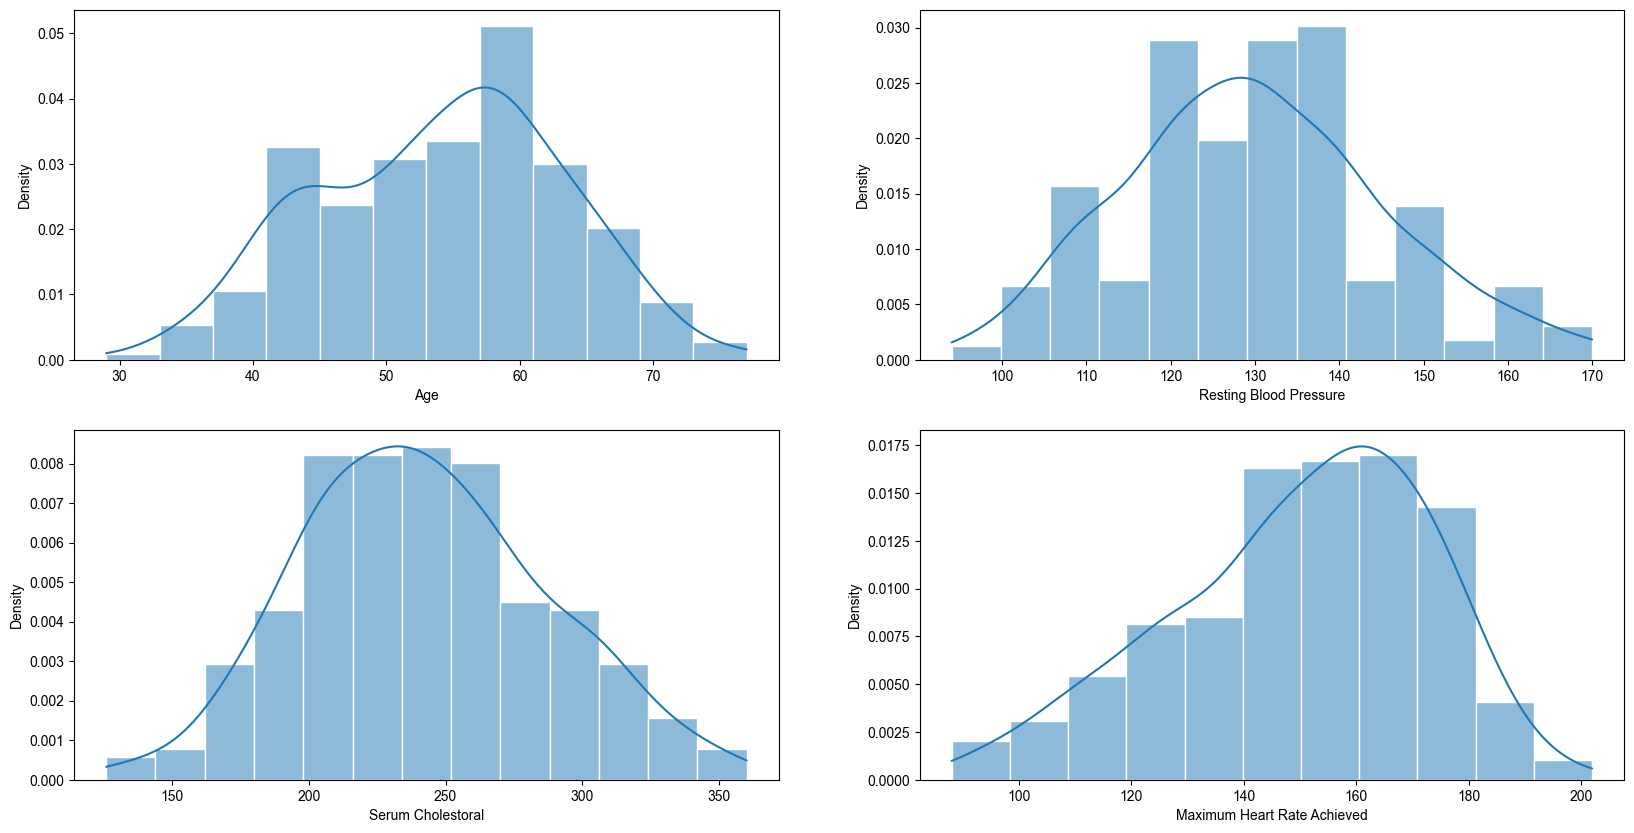

In [14]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid', palette='pastel')

age = sns.histplot(df.age, ax=ax[0, 0], kde=True, stat='density')
age.set(xlabel='Age')

trestbps = sns.histplot(df.trestbps, ax=ax[0, 1], kde=True, stat='density')
trestbps.set(xlabel='Resting Blood Pressure')

chol = sns.histplot(df.chol, ax=ax[1, 0], kde=True, stat='density')
chol.set(xlabel='Serum Cholestoral')

thalach = sns.histplot(df.thalach, ax=ax[1, 1], kde=True, stat='density')
thalach.set(xlabel='Maximum Heart Rate Achieved')

plt.show()

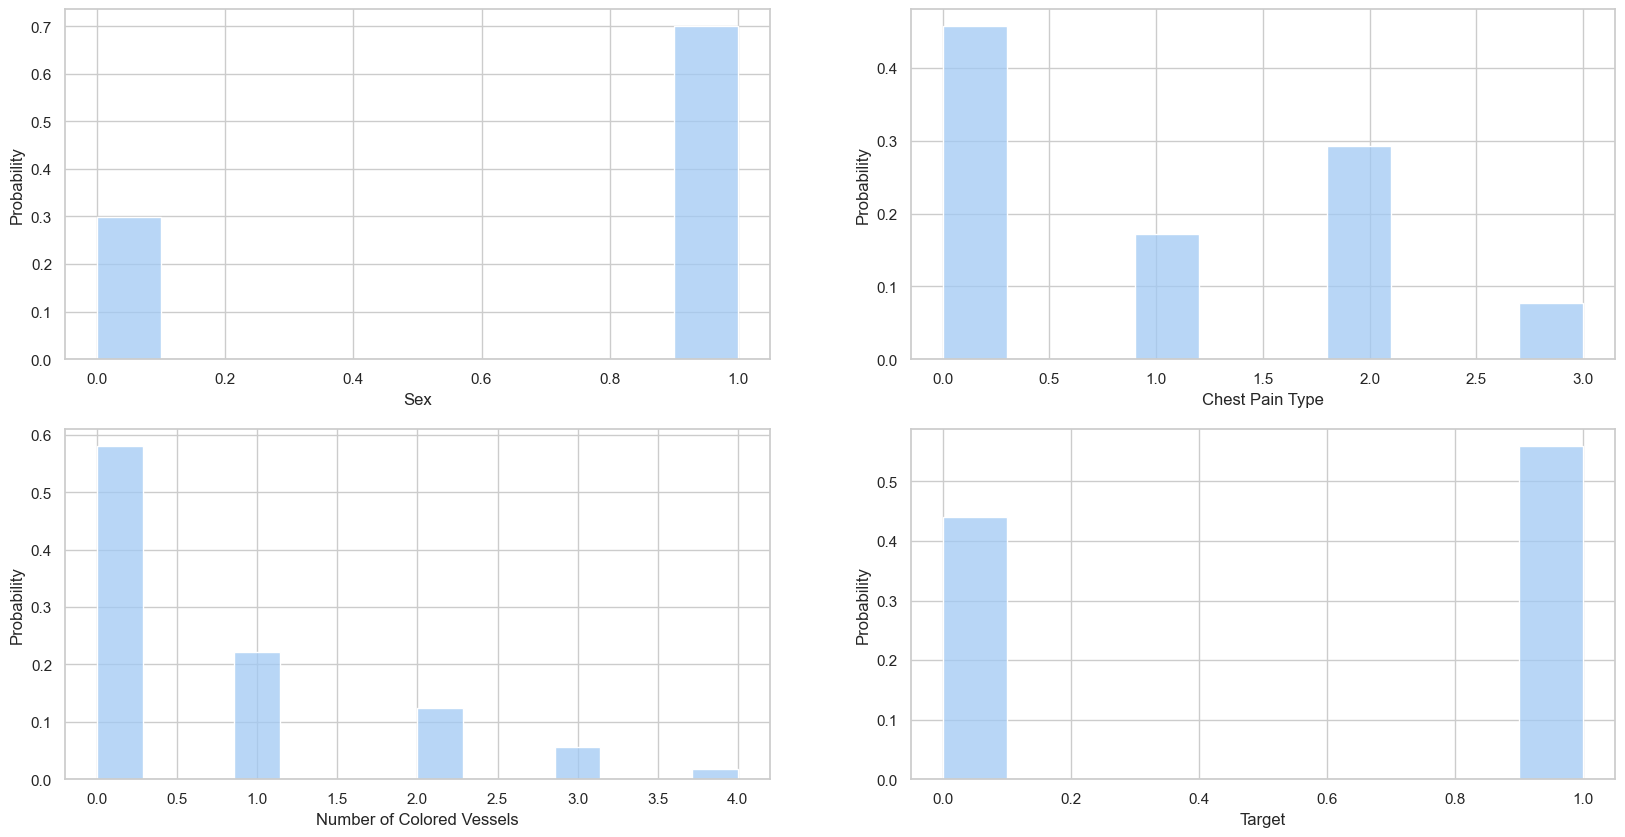

In [16]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sex = sns.histplot(df.sex, ax=ax[0, 0], kde=False, stat='probability')
sex.set(xlabel='Sex')

cp = sns.histplot(df.cp, ax=ax[0, 1], kde=False, stat='probability')
cp.set(xlabel='Chest Pain Type')

ca = sns.histplot(df.ca, ax=ax[1, 0], kde=False, stat='probability')
ca.set(xlabel='Number of Colored Vessels')

target = sns.histplot(df.target, ax=ax[1, 1], kde=False, stat='probability')
target.set(xlabel='Target')

plt.show()

##### Fitting a regression model. Estimation of the confidence interval for the result

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Assuming you have a DataFrame 'df' with the selected columns
# X = Features, y = Target variable
X = df[['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'slope']]
y = df['target']

# Split the data into a training set and a testing set (you can adjust the test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate confidence intervals for the predictions
X_test = sm.add_constant(X_test)  # Add a constant term (intercept) to the features

# Create a linear regression model using statsmodels
model_sm = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Calculate predictions with confidence intervals
predictions = model_sm.get_prediction(X_test)
predicted_values = predictions.predicted_mean
conf_int = predictions.conf_int()

# Display the predicted values and confidence intervals
result = pd.DataFrame({'Predicted': predicted_values, 'Lower CI': conf_int[:, 0], 'Upper CI': conf_int[:, 1]})

print(result)

    Predicted  Lower CI  Upper CI
0    0.099755 -0.055176  0.254685
1    0.801201  0.604162  0.998240
2    0.786083  0.615716  0.956451
3    0.172280 -0.022169  0.366729
4    0.890116  0.710001  1.070230
..        ...       ...       ...
86  -0.394130 -0.605205 -0.183054
87   0.805158  0.607662  1.002654
88   0.508331  0.324443  0.692220
89   0.718621  0.580822  0.856420
90   0.779266  0.585782  0.972750

[91 rows x 3 columns]


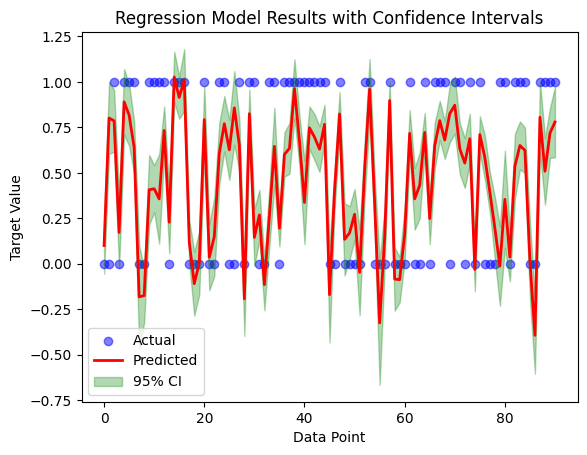

In [4]:
# Plot the actual test values
plt.scatter(range(len(y_test)), y_test, color='b', label='Actual', alpha=0.5)

# Plot the predicted values
plt.plot(range(len(y_test)), y_pred, color='r', label='Predicted', lw=2)

# Plot the confidence intervals
plt.fill_between(range(len(y_test)), conf_int[:, 0], conf_int[:, 1], color='g', alpha=0.3, label='95% CI')

plt.xlabel('Data Point')
plt.ylabel('Target Value')
plt.title('Regression Model Results with Confidence Intervals')
plt.legend()
plt.show()

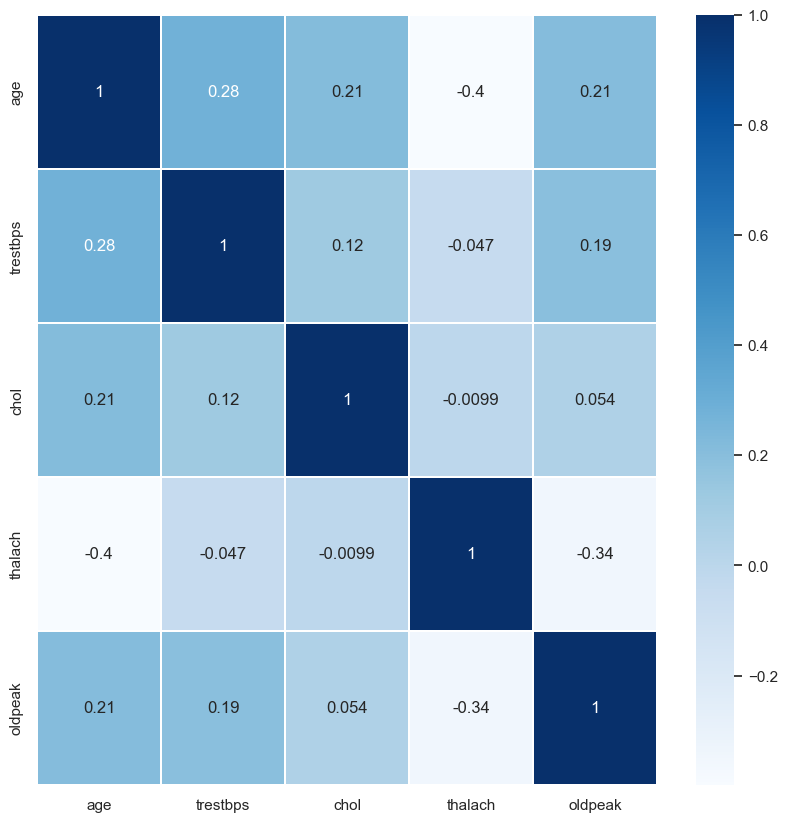

In [26]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].corr(), cmap='Blues', annot=True, linewidths=0.25)

plt.show()

##### Fitting a Bayesian regression model. Estimation of probability interval for prediction

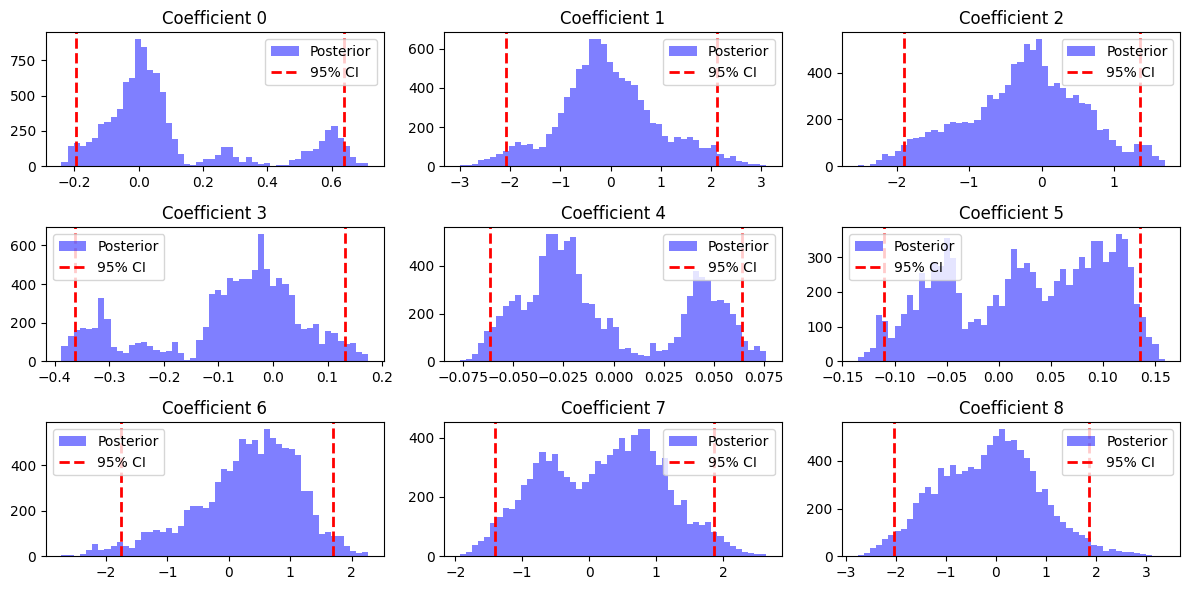

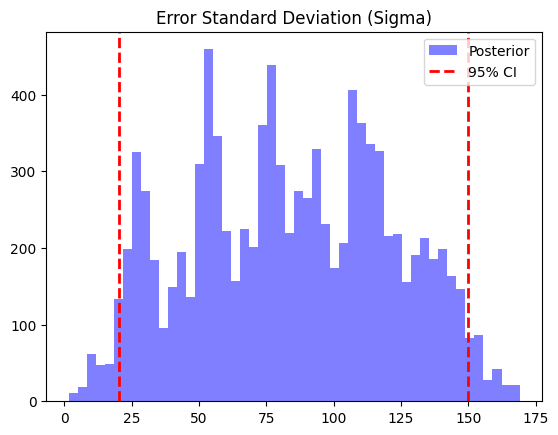

In [8]:
X = df[['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'slope']]
y = df['target']

# Define the Bayesian linear regression model
def bayesian_regression(X, y, n_samples=10000):
    n, k = X.shape
    beta = np.zeros(k)
    sigma = 1.0

    # Lists to store samples
    beta_samples = []
    sigma_samples = []

    # Initialize the proposal distribution
    proposal_beta = np.zeros(k)
    proposal_sigma = 1.0

    for _ in range(n_samples):
        # Sample from the proposal distribution for beta and sigma
        beta_candidate = np.random.multivariate_normal(beta, proposal_sigma**2 * np.linalg.inv(X.T @ X))
        sigma_candidate = np.abs(np.random.normal(sigma, proposal_sigma))

        # Calculate the likelihood for the candidates
        likelihood_current = np.exp(-0.5 * np.sum((y - X @ beta)**2) / sigma**2)
        likelihood_candidate = np.exp(-0.5 * np.sum((y - X @ beta_candidate)**2) / sigma_candidate**2)

        # Calculate the prior for the candidates
        prior_current = np.exp(-0.5 * np.sum(beta**2))
        prior_candidate = np.exp(-0.5 * np.sum(beta_candidate**2))

        # Calculate the acceptance ratio
        acceptance_ratio = (likelihood_candidate * prior_candidate) / (likelihood_current * prior_current)

        # Accept or reject the candidates
        if np.random.uniform(0, 1) < acceptance_ratio:
            beta = beta_candidate
            sigma = sigma_candidate

        # Store samples
        beta_samples.append(beta)
        sigma_samples.append(sigma)

    return np.array(beta_samples), np.array(sigma_samples)

# Run the Bayesian regression
beta_samples, sigma_samples = bayesian_regression(X, y)

# Calculate credible intervals for beta and sigma
lower_beta = np.percentile(beta_samples, 2.5, axis=0)
upper_beta = np.percentile(beta_samples, 97.5, axis=0)
lower_sigma = np.percentile(sigma_samples, 2.5)
upper_sigma = np.percentile(sigma_samples, 97.5)

# Plot the credible intervals for beta
plt.figure(figsize=(12, 6))
for i in range(X.shape[1]):
    plt.subplot(3, 3, i+1)
    plt.hist(beta_samples[:, i], bins=50, color='blue', alpha=0.5, label='Posterior')
    plt.axvline(lower_beta[i], color='red', linestyle='--', linewidth=2, label='95% CI')
    plt.axvline(upper_beta[i], color='red', linestyle='--', linewidth=2)
    plt.title(f'Coefficient {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot the credible interval for sigma
plt.figure()
plt.hist(sigma_samples, bins=50, color='blue', alpha=0.5, label='Posterior')
plt.axvline(lower_sigma, color='red', linestyle='--', linewidth=2, label='95% CI')
plt.axvline(upper_sigma, color='red', linestyle='--', linewidth=2)
plt.title('Error Standard Deviation (Sigma)')
plt.legend()
plt.show()


##### Fitting a Bayesian network

In [26]:
def inverse_transform_sampling(array, distribution):
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    data = np.random.uniform(size=len(array))
    sample = distribution(*args)
    sample= sample.ppf(data)
    return sample

def custom_sampling(array, distribution):
    args = distribution.fit(array)
    sample = distribution.rvs(*args, size=len(array))
    return sample

def return_cdf(array):
    bins, x = np.histogram(array, bins=100)
    probas = bins / sum(bins)
    y = np.cumsum(probas)
    return x[:100], y[:100]

df_its = pd.DataFrame(data={
    'age': inverse_transform_sampling(df.age, distribution=scipy.stats.beta),
    'trestbps': inverse_transform_sampling(df.trestbps, distribution=scipy.stats.gamma),
    'chol': inverse_transform_sampling(df.chol, distribution=scipy.stats.norm),
    'thalach': inverse_transform_sampling(df.thalach, distribution=scipy.stats.beta),
    'oldpeak': inverse_transform_sampling(df.oldpeak, distribution=scipy.stats.beta),
    'ca': df.ca,
    'slope': df.slope,
    'target': df.target,
    'cp': df.cp
})


df_its.head(10)
predictors = df_its[['age', 'oldpeak', 'cp', 'target']]
target = df_its[['slope']]

df_its.drop(['thalach'], axis=1, inplace=True)
df_its.drop(['ca'], axis=1, inplace=True)

df_transformed = df_its.copy()
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(df_its.values[:, [0, 1, 2, 3]])
df_transformed[['age', 'trestbps', 'chol', 'oldpeak']] = df_discretized

df_transformed.head(10)

Distribution beta_gen arguments: (5.508105505173706, 4.345879427169967, 20.83830978123914, 59.95268630033878)
Distribution gamma_gen arguments: (10.36626093173776, 75.4918893791302, 5.414862453388054)
Distribution norm_gen arguments: (246.26402640264027, 51.74515101045713)
Distribution beta_gen arguments: (30.4974296351785, 6.318093236525403, -158.44847495145063, 371.91912445209755)
Distribution beta_gen arguments: (0.7341572779976595, 8.358188313905483, -1.2252224048353046e-30, 10.983676294206322)


,age,trestbps,chol,oldpeak,slope,target,cp
0,1.0,0.0,1.0,1.0,0,1,3
1,0.0,0.0,1.0,0.0,0,1,2
2,0.0,1.0,0.0,1.0,2,1,1
3,1.0,1.0,1.0,0.0,2,1,1
4,0.0,1.0,0.0,0.0,2,1,0
5,0.0,1.0,1.0,0.0,1,1,0
6,0.0,0.0,1.0,0.0,1,1,1
7,1.0,1.0,0.0,0.0,2,1,1
8,0.0,0.0,1.0,0.0,2,1,2
9,0.0,0.0,0.0,0.0,2,1,2


In [2]:
edges_list = [
    ('age', 'trestbps'),
    ('oldpeak', 'trestbps'),
    ('trestbps', 'slope'),
    ('target', 'trestbps'),
    ('cp', 'slope')
]

our_model = BayesianModel(edges_list)

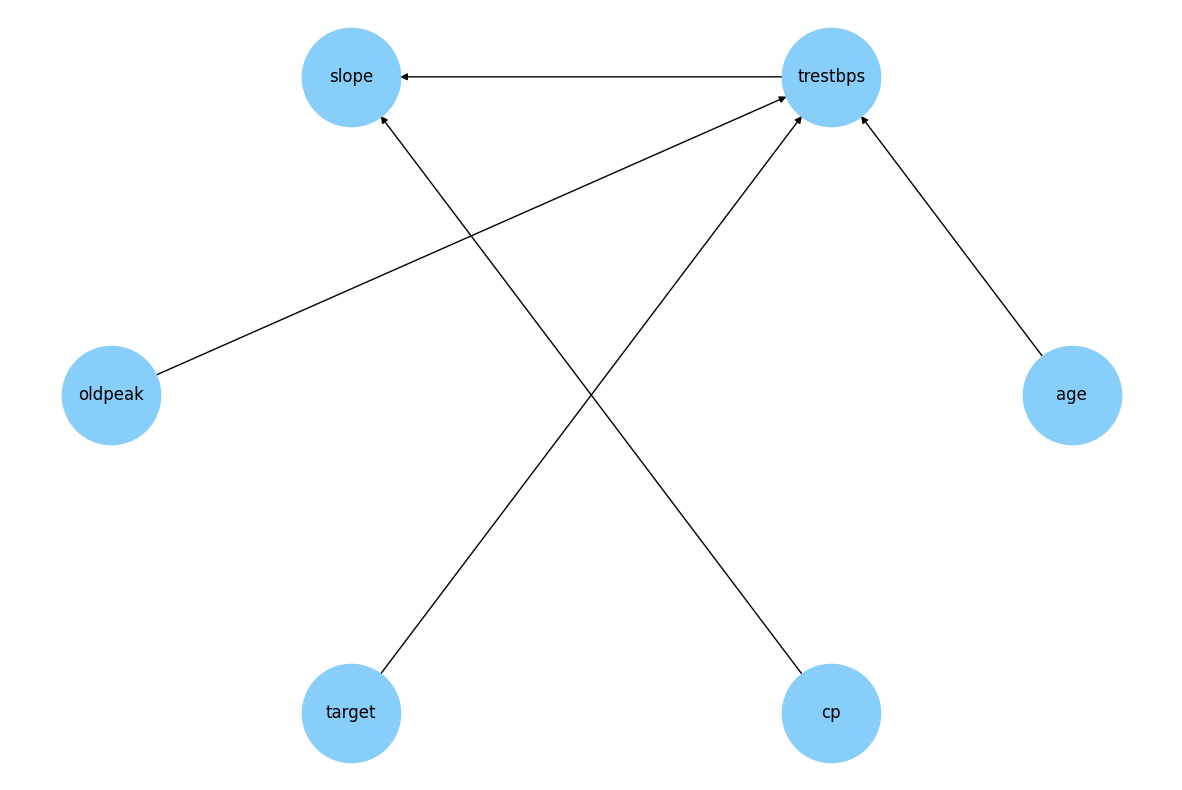

In [3]:
figure, ax = plt.subplots(1, 1, figsize=(15, 10))

graph = nx.DiGraph()
graph.add_edges_from(our_model.edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

##### Sampling и inference of MAP value. Estimation of credible interval for posterior distribution

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    df[['oldpeak', 'trestbps', 'thalach']],
    df['age']
)

In [11]:
lars = Lars()
lars.fit(x_train, y_train)

mae = mean_absolute_error(y_test, lars.predict(x_test))
mse = mean_squared_error(y_test, lars.predict(x_test))
r2 = r2_score(y_test, lars.predict(x_test))

print('Mean Absolute Error: {:.3f}'.format(mae))
print('Mean Squared Error: {:.3f}'.format(mse))
print('R2 Score: {:.3f}'.format(r2))

Mean Absolute Error: 5.981
Mean Squared Error: 53.232
R2 Score: 0.181


In [14]:
lregressor = LinearRegression()
lregressor.fit(x_train, y_train)

mae = mean_absolute_error(y_test, lregressor.predict(x_test))
mse = mean_squared_error(y_test, lregressor.predict(x_test))
r2 = r2_score(y_test, lregressor.predict(x_test))

print('Mean Absolute Error: {:.3f}'.format(mae))
print('Mean Squared Error: {:.3f}'.format(mse))
print('R2 Score: {:.3f}'.format(r2))

Mean Absolute Error: 5.981
Mean Squared Error: 53.232
R2 Score: 0.181


In [15]:
elastic = ElasticNet()
elastic.fit(x_train, y_train)

mae = mean_absolute_error(y_test, elastic.predict(x_test))
mse = mean_squared_error(y_test, elastic.predict(x_test))
r2 = r2_score(y_test, elastic.predict(x_test))

print('Mean Absolute Error: {:.3f}'.format(mae))
print('Mean Squared Error: {:.3f}'.format(mse))
print('R2 Score: {:.3f}'.format(r2))

Mean Absolute Error: 5.998
Mean Squared Error: 53.283
R2 Score: 0.180


##### Аnalysis and comparison of point estimations of quality and intervals for regression results

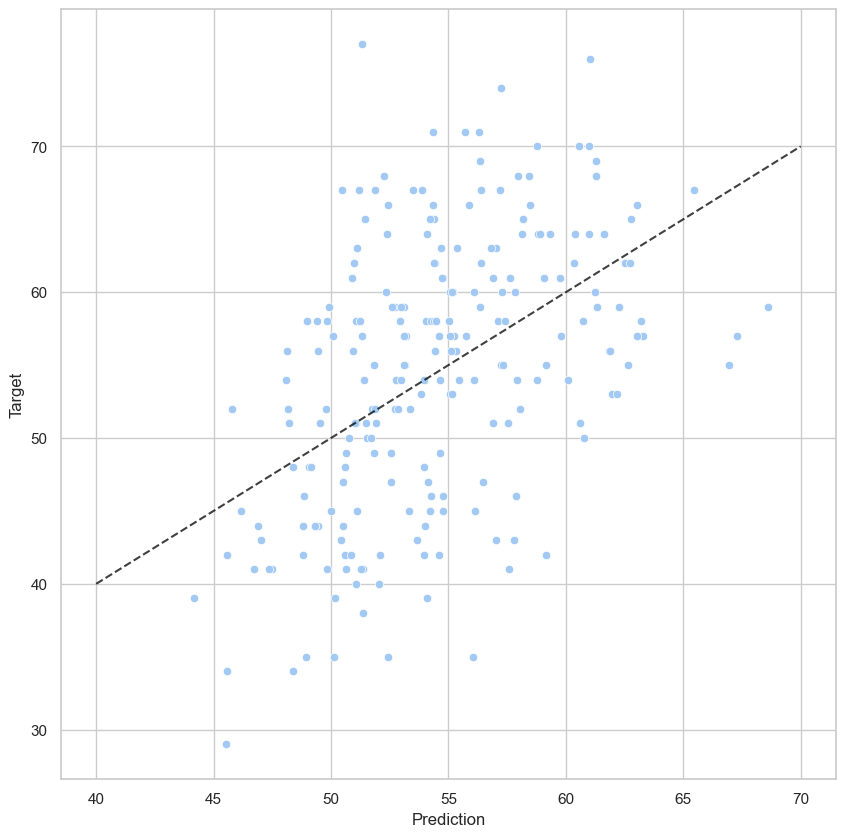

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame with columns 'y_logits' and 'y_target'
data = pd.DataFrame({'y_logits': y_logits, 'y_target': y_target})

figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.scatterplot(data=data, x='y_logits', y='y_target', ax=ax)

# Plot a diagonal line using Matplotlib
ax.plot([40, 70], [40, 70], color='black', linestyle='--', alpha=0.75)

plt.xlabel('Prediction')
plt.ylabel('Target')

plt.show()


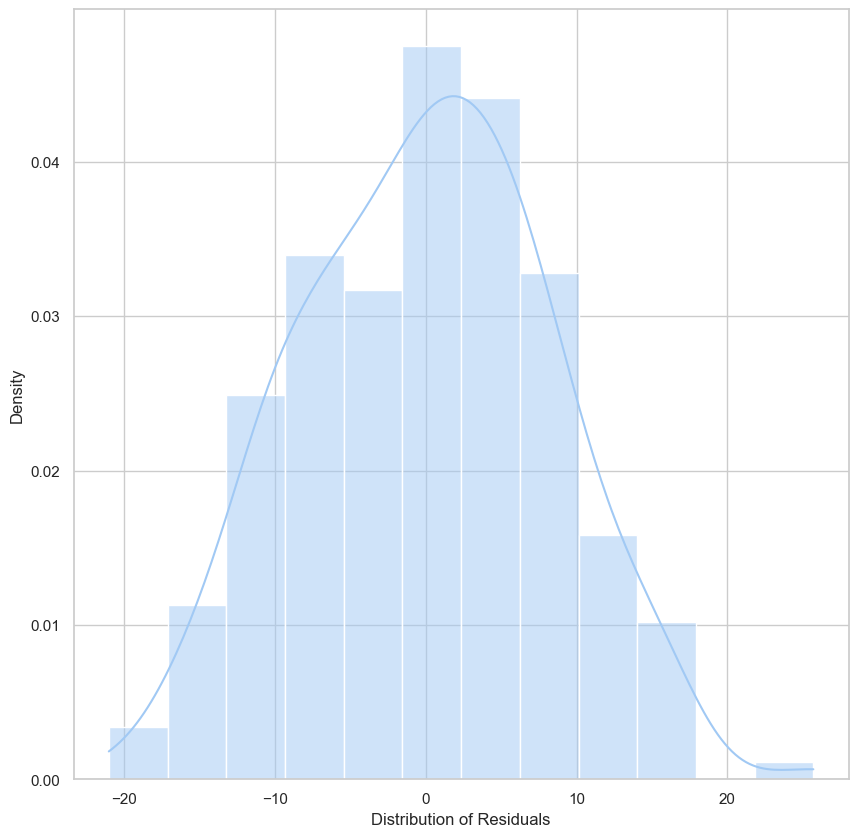

In [20]:
data = y_target - y_logits

figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

residuals = sns.histplot(data, ax=ax, kde=True, stat='density')
residuals.set(xlabel='Distribution of Residuals')

plt.show()

In [21]:
def return_test(array, distribution, cdf):
    args = distribution.fit(array)
    
    kstest = scipy.stats.kstest(array, cdf=cdf, args=args).pvalue
    cramervonmises = scipy.stats.cramervonmises(array, cdf=cdf, args=args).pvalue
    
    print('Kolmogorov-Smirnov Test: {:.5f}'.format(kstest))
    print('Cramer–Von Mises Test: {:.5f}'.format(cramervonmises))

In [22]:
return_test(data, distribution=scipy.stats.norm, cdf='norm')

Kolmogorov-Smirnov Test: 0.85177
Cramer–Von Mises Test: 0.85303


In [23]:
def return_biplot(array, distribution):
    figure, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    args = distribution.fit(array)
    scipy.stats.probplot(array, dist=distribution, sparams=(args), plot=ax)
    
    ax.get_lines()[0].set_marker('o')
    
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)
    
    plt.show()

In [24]:
data.mean()


1.095550473638921e-15

In [25]:
data.var()


67.05211314779109